In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
class DataGenerator(object):
    def __init__(self, annFile, dataDir):
        self._annFile = annFile
        self._dataDir = dataDir
        self._coco = COCO(annFile)
        
    def getBatch(self, n=100, imgIds=None, expandMasks=False):
        if imgIds is None:
            ids = self._coco.getImgIds()
            imgIds = ids[:n]
        
        imgs = self._coco.loadImgs(ids=imgIds)

        images = []
        labels = []
        for img in imgs:
            I = io.imread('{}/{}'.format(dataDir, img['file_name']))
            images.append(np.moveaxis(I, -1, 0))
            annIds = self._coco.getAnnIds(imgIds=img['id'])
            anns = self._coco.loadAnns(annIds)
            if expandMasks:
                res = np.zeros((max(self._coco.getCatIds()) + 1,
                                I.shape[0], I.shape[1]))
                for ann in anns:
                    mask = self._coco.annToMask(ann)
                    res[ann['category_id']] = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']])

                labels.append(res)
            else:
                res = np.zeros((I.shape[0], I.shape[1]), dtype=np.int32)
                for ann in anns:
                    mask = self._coco.annToMask(ann) * ann['category_id']
                    res = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']]
                    )
                labels.append(res)

        return images, labels
        

In [3]:
annFile = 'annotations/instances_train2017.json'
dataDir = 'train2017'

In [88]:
gen = DataGenerator(annFile, dataDir)

loading annotations into memory...
Done (t=19.36s)
creating index...
index created!


In [89]:
images, labels = gen.getBatch(50, expandMasks=True)
labels[0].shape

(91, 427, 640)

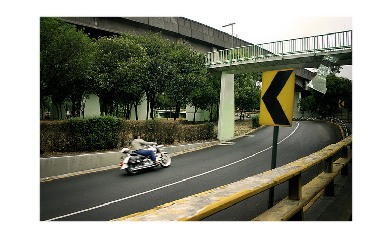

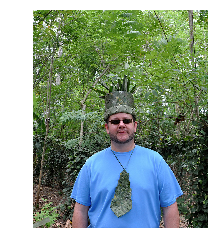

In [91]:
#content = images[43]
#style = images[2]
content = images[45]
style = images[16]
plt.figure(1)
plt.axis('off')
plt.imshow(np.moveaxis(content, 0, -1))

plt.figure(2)
plt.axis('off')

plt.imshow(np.moveaxis(style, 0, -1))
plt.show()

#content_masks = labels[43]
#style_masks = labels[2]
content_masks = labels[45]
style_masks = labels[16]

del labels
del images
del gen

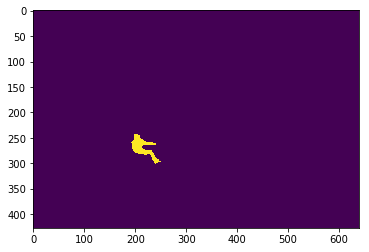

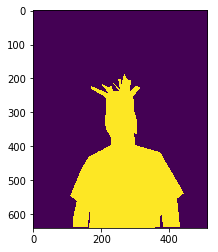

In [93]:
plt.figure(1)
plt.imshow(content_masks[1])
plt.show()

plt.figure(2)
plt.imshow(style_masks[1])
plt.show()

In [94]:
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg19, vgg19_bn
from torch.nn.functional import conv3d
import itertools

In [299]:
def get_patch(x, j, k, T):
    return x[0, :, j: T + j, k : k + T]

def extract_patches(x, newH, newW, T):
    return torch.cat([get_patch(x, i, j, T).unsqueeze(0) for i, j in itertools.product(range(newH), range(newW))], dim=0)


def preprocess_masks(content_masks, style_masks, H, W, T):
    newH, newW = H - T + 1, W - T + 1
    
    style_patches = extract_patches(style_masks, newH, newW, T)
    
    norm = (((style_patches.unsqueeze(1) ** 2).sum(-1).sum(-1)) ** 0.5).unsqueeze(-1).unsqueeze(-1)
    
    return conv3d(content_masks.unsqueeze(0), style_patches.unsqueeze(1) / norm)

def adjust_lr(optimizer, init_lr, decay, epoch):
    lr = init_lr * (decay ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def normalize(tensor):
    positive = tensor - torch.min(tensor)
    return positive / torch.max(positive)
                                
def extract_layer_masks(initial_masks, h, w, beta, use_cuda=True):
    if torch.cuda.is_available and use_cuda:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)).cuda(), requires_grad=False)
    else:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)), requires_grad=False)

def downsample(imgs, sz):
    """Downsample a sequence of binary images to a given size."""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(sz),
        transforms.ToTensor(),
    ])
    
    return torch.cat([transform(x.view((1, *x.shape))).view((1, 1, *sz)) for x in imgs], dim=1)

def prepare_img(img, requires_grad=False, use_cuda=True, resize=None):
    tens = -torch.FloatTensor(img) # PIL Image inverts tensor for some reason
    
    if resize is not None:
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])

        tens = transform(tens)
    

    if torch.cuda.is_available() and use_cuda:
        return Variable(tens.unsqueeze(0).cuda(), requires_grad=requires_grad)
    else:
        return Variable(tens.unsqueeze(0), requires_grad=requires_grad)

class StyleTransfer(object):
    class VGGExtractor(nn.Module):
        def __init__(self, use_cuda=True):
            super(VGGExtractor, self).__init__()
            model = vgg19_bn(pretrained=True)
            if torch.cuda.is_available() and use_cuda:
                model = model.cuda()

            self.first = nn.Sequential(*[model.features[i] for i in range(17)])
            self.second = nn.Sequential(*[model.features[i] for i in range(17, 30)])

            for param in model.parameters():
                param.requires_grad = False

        def forward(self, x):
            conv3_1 = self.first.forward(x)
            conv4_1 = self.second.forward(conv3_1)
            return conv3_1, conv4_1
    
    def __init__(self):
        self.nn = VGGExtractor()
        print(self.nn.first)
        print(self.nn.second)
        
    def get_style_loss(self, content_masks, style_masks, gen_layer, style_layer, masks_product, T):
        _, _, H, W = style_layer.shape
        newH, newW = H - T + 1, W - T + 1

        p_s = extract_patches(style_layer, newH, newW, T)
        norm = (((p_s.unsqueeze(1) ** 2).sum(-1).sum(-1)) ** 0.5).unsqueeze(-1).unsqueeze(-1)

        feature_product = conv3d(gen_layer.unsqueeze(0), p_s.unsqueeze(1) / norm)

        NN = torch.min(feature_product + masks_product, 1)[1]

        s = torch.cat((style_layer, style_masks), dim=1)
        p_s = extract_patches(s, newH, newW, T)

        g = torch.cat((gen_layer, content_masks), dim=1)
        p_g = extract_patches(g, newH, newW, T)

        p_s = p_s[NN.view(-1)]
        
        self.debug['NN'].append(NN.data.cpu())
        self.debug['feature_product'].append(feature_product.data.cpu())
        self.debug['mask_product'].append(masks_product.data.cpu())

        return ((p_g - p_s) ** 2).sum()    
    
        
    def generate(self, gen_img, content, style, content_masks, style_masks, lr, decay, n_iter, sz=None):
        if sz is None:
            h, w = content.shape[-2:]
        else:
            h, w = sz
        
        # Initialize generated image
        
        if gen_img is None:
            gen_img = np.random.randint(0, 255, content.shape, dtype=np.uint8)

        gen_var = prepare_img(gen_img, requires_grad=True, resize=(h, w))

        
        style3_1, style4_1 = self.nn.forward(prepare_img(style, resize=(h, w)))
        cont3_1, cont4_1 = self.nn.forward(prepare_img(content, resize=(h, w)))
        
        # set model parameters
        
        ALPHA_1 = 20
        ALPHA_2 = 1e-4

        BETA = 0

        T = 3
        
        # produce masks for augmented layers
        
        h, w = style3_1.shape[2:]

        content_masks_3_1 = extract_layer_masks(content_masks, h, w, BETA)
        style_masks_3_1 = extract_layer_masks(style_masks, h, w, BETA)
        masks_prod_3_1 = preprocess_masks(content_masks_3_1, style_masks_3_1, h, w, T)


        h, w = style4_1.shape[2:]
        content_masks_4_1 = extract_layer_masks(content_masks, h, w, BETA)
        style_masks_4_1 = extract_layer_masks(style_masks, h, w, BETA)
        masks_prod_4_1 = preprocess_masks(content_masks_4_1, style_masks_4_1, h, w, T)

        # initialize optimizer
        
        optimizer = optim.Adam([gen_var])
        
        ### initialize debug info
        
        self.debug = {}
        self.debug['loss'] = []
        self.debug['content_loss'] = []
        self.debug['style_loss_3_1'] = []
        self.debug['style_loss_4_1'] = []
        self.debug['NN'] = []
        self.debug['feature_product'] = []
        self.debug['mask_product'] = []

        for i in range(n_iter):
            adjust_lr(optimizer, lr, decay, i)
            optimizer.zero_grad()

            gen3_1, gen4_1 = self.nn.forward(normalize(gen_var))

            style_loss_3_1 = self.get_style_loss(content_masks_3_1, style_masks_3_1, gen3_1, style3_1,
                                            masks_prod_3_1, T)
            style_loss_4_1 = self.get_style_loss(content_masks_4_1, style_masks_4_1, gen4_1, style4_1,
                                            masks_prod_4_1, T)

            content_loss = ((cont3_1 - gen3_1) ** 2).sum() + ((cont4_1 - gen4_1) ** 2).sum()

            loss = ALPHA_1 * content_loss + ALPHA_2 * (style_loss_4_1 + style_loss_3_1)

            self.debug['loss'].append(loss.data[0])
            self.debug['content_loss'].append(content_loss.data[0])
            self.debug['style_loss_3_1'].append(style_loss_3_1.data[0])
            self.debug['style_loss_4_1'].append(style_loss_4_1.data[0])
            
            if i % 200 == 0:
                print("Iteration:", i, "Loss:", loss.data[0])
                print("Content Loss:", content_loss.data[0]* ALPHA_1)
                print("Style Loss 3_1:", style_loss_3_1.data[0] * ALPHA_2)
                print("Style Loss 4_1:", style_loss_4_1.data[0] * ALPHA_2)
            loss.backward()
            optimizer.step()

        return gen_var.data.cpu(), losses


    
    

In [300]:
trans = StyleTransfer()
    

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
)
Sequential(
  (0): Conv2d (256, 256, kernel_size=(3, 3

In [301]:
gen_img, losses = trans.generate(
    gen_img=None,
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=10.0,
    decay=0.9,
    n_iter=1000,
    sz=(64, 64)
)

Iteration: 0 Loss: 42740.828125
Content Loss: 42739.033203125
Style Loss 3_1: 1.4439103515625
Style Loss 4_1: 0.35279812011718753
Iteration: 200 Loss: 16179.29296875
Content Loss: 16177.498779296875
Style Loss 3_1: 1.4285768554687501
Style Loss 4_1: 0.3649072265625
Iteration: 400 Loss: 9761.943359375
Content Loss: 9760.145263671875
Style Loss 3_1: 1.4308686523437502
Style Loss 4_1: 0.36665834960937504
Iteration: 600 Loss: 7070.47119140625
Content Loss: 7068.671875
Style Loss 3_1: 1.4319275390625001
Style Loss 4_1: 0.3672367431640625
Iteration: 800 Loss: 5673.2041015625
Content Loss: 5671.4044189453125
Style Loss 3_1: 1.4327232421875
Style Loss 4_1: 0.3673169921875


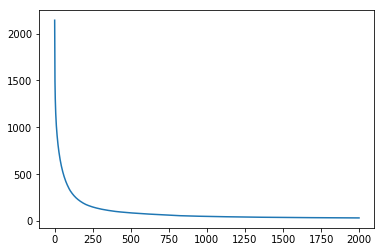

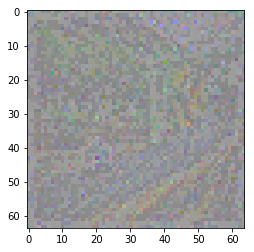

In [302]:
plt.figure(1)
plt.plot(range(len(losses)), losses)

plt.figure(2)
plt.imshow(np.moveaxis(normalize(gen_img[0]).numpy(), 0, -1))
plt.show()

In [306]:
trans.debug['feature_product'][2]


( 0 , 0 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
          ⋮  

( 0 , 1 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
          ⋮  

( 0 , 2 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
    ...     
          ⋮  

( 0 ,193, 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  n

In [308]:
trans.debug['mask_product'][0]


( 0 , 0 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
          ⋮  

( 0 , 1 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
          ⋮  

( 0 , 2 , 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
    ...     
          ⋮  

( 0 ,193, 0 ,.,.) = 
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
     ...       ⋱       ...    
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  nan nan nan
 nan nan nan  ...  n

In [ ]:
gen_img, losses = trans.generate(
    gen_img=gen_img.numpy()[0],
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=10.0,
    decay=0.75,
    n_iter=1000,
    sz=(256, 256)
)

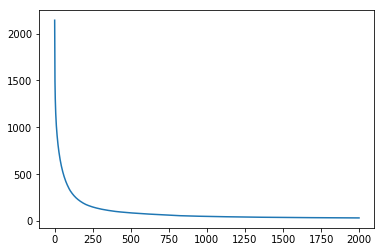

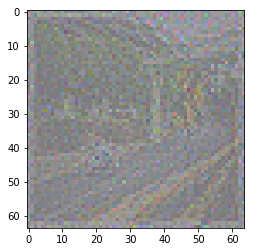

In [266]:
plt.figure(1)
plt.plot(range(len(losses)), losses)

plt.figure(2)
plt.axis('on')
plt.imshow(np.moveaxis(normalize(gen_img[0]).numpy(), 0, -1))
plt.show()

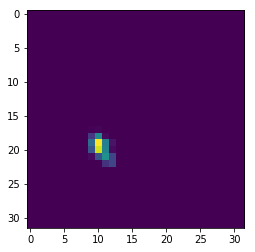

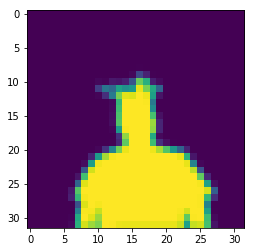

In [267]:
plt.figure(1)
plt.imshow(content_masks_3_1[0, 1].cpu().data.numpy())
plt.show()

plt.figure(2)
plt.imshow(style_masks_3_1[0, 1].cpu().data.numpy())
plt.show()